In [1]:
spark


In [2]:
from pyspark.sql.functions import col, isnan, isnull, when, count, udf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [3]:
config_file_path = 'config.json'

with open(config_file_path, 'r') as config_file:
    config = json.load(config_file)

sc.setLogLevel("ERROR")
#acccessing gcs csv
bucket = config["bucket"]
filename = config["cleaningfilename"]
file_path = 'gs://'+ bucket+'/'+filename

sdf= spark.read.csv(file_path, sep=',', header=True, inferSchema=True)

sdf.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [4]:
sdf.count()
#num of observations

82138753

In [5]:
sdf.columns
#list of variables

['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'fareBasisCode',
 'travelDuration',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeEpochSeconds',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeEpochSeconds',
 'segmentsArrivalTimeRaw',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'segmentsAirlineName',
 'segmentsAirlineCode',
 'segmentsEquipmentDescription',
 'segmentsDurationInSeconds',
 'segmentsDistance',
 'segmentsCabinCode']

In [6]:
sdf.select([count(when(isnull(c), c)).alias(c) for c in ['legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineCode', 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode'
]]).show()
#missing null

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineCode|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------------------------------+------

In [7]:
sdf.select([count(when(isnull(c), c)).alias(c) for c in ['totalTravelDistance','segmentsEquipmentDescription', 'seatsRemaining', 'segmentsAirlineName', 'totalFare']]).show()
#missing null

+-------------------+----------------------------+--------------+-------------------+---------+
|totalTravelDistance|segmentsEquipmentDescription|seatsRemaining|segmentsAirlineName|totalFare|
+-------------------+----------------------------+--------------+-------------------+---------+
|            6094532|                     1557592|             0|                  0|        0|
+-------------------+----------------------------+--------------+-------------------+---------+



In [8]:
sdf.select("elapsedDays","isBasicEconomy", "isRefundable", "isNonStop","seatsRemaining", "totalTravelDistance", "baseFare", "totalFare").summary("count", "min", "max", "mean").show()
#min/max/count of numeric values

+-------+-------------------+-----------------+-------------------+-----------------+------------------+
|summary|        elapsedDays|   seatsRemaining|totalTravelDistance|         baseFare|         totalFare|
+-------+-------------------+-----------------+-------------------+-----------------+------------------+
|  count|           82138753|         82138753|           76044221|         82138753|          82138753|
|    min|                  0|                0|                 89|             0.01|             19.59|
|    max|                  2|               10|               7252|          7662.33|           8260.61|
|   mean|0.14965308762357277|5.976311522528228| 1609.9033457519408|292.6628527106181|340.38684913979074|
+-------+-------------------+-----------------+-------------------+-----------------+------------------+



In [9]:
from pyspark.sql import functions as F
sdf.select(F.max("searchDate").alias("search_max_date"),F.min("searchDate").alias("search_min_date")).show()
sdf.select(F.max("flightDate").alias("flight_max_date"),F.min("flightDate").alias("flight_min_date")).show()

+---------------+---------------+
|search_max_date|search_min_date|
+---------------+---------------+
|     2022-10-05|     2022-04-16|
+---------------+---------------+



+---------------+---------------+
|flight_max_date|flight_min_date|
+---------------+---------------+
|     2022-11-19|     2022-04-17|
+---------------+---------------+



In [10]:
sac_unique = sdf.select('segmentsAirlineCode').distinct().collect()
sac_unique
#checking if codes are unique 

[Row(segmentsAirlineCode='UA||9X||9X'),
 Row(segmentsAirlineCode='UA||DL'),
 Row(segmentsAirlineCode='DL||9K||9K||UA'),
 Row(segmentsAirlineCode='AS||UA'),
 Row(segmentsAirlineCode='DL||DL||UA||UA'),
 Row(segmentsAirlineCode='AS||AS'),
 Row(segmentsAirlineCode='UA||UA||AS||AS'),
 Row(segmentsAirlineCode='DL||AS||AS'),
 Row(segmentsAirlineCode='KG||KG||AA'),
 Row(segmentsAirlineCode='9K||9K||DL||DL'),
 Row(segmentsAirlineCode='9K||9K||9K||DL'),
 Row(segmentsAirlineCode='DL||UA||UA'),
 Row(segmentsAirlineCode='UA||UA||AS'),
 Row(segmentsAirlineCode='UA||9K||9K||UA'),
 Row(segmentsAirlineCode='AA||LF||LF'),
 Row(segmentsAirlineCode='AS'),
 Row(segmentsAirlineCode='UA||UA'),
 Row(segmentsAirlineCode='F9||F9||F9'),
 Row(segmentsAirlineCode='4B||4B||AA'),
 Row(segmentsAirlineCode='AA'),
 Row(segmentsAirlineCode='UA||AS'),
 Row(segmentsAirlineCode='UA||UA||UA||UA'),
 Row(segmentsAirlineCode='B6'),
 Row(segmentsAirlineCode='DL||DL||DL'),
 Row(segmentsAirlineCode='LF||LF||AA'),
 Row(segmentsAir

In [11]:
scc_unique = sdf.select('segmentsCabinCode').distinct().collect()
scc_unique
#checking if codes are unique 

[Row(segmentsCabinCode='first||coach'),
 Row(segmentsCabinCode='premium coach||premium coach||coach'),
 Row(segmentsCabinCode='premium coach||coach||coach'),
 Row(segmentsCabinCode='coach||coach||first'),
 Row(segmentsCabinCode='coach||coach||business'),
 Row(segmentsCabinCode='coach||business||business'),
 Row(segmentsCabinCode='first||first||coach'),
 Row(segmentsCabinCode='first||first||first'),
 Row(segmentsCabinCode='first'),
 Row(segmentsCabinCode='coach||business'),
 Row(segmentsCabinCode='premium coach||premium coach'),
 Row(segmentsCabinCode='premium coach||coach'),
 Row(segmentsCabinCode='first||coach||coach'),
 Row(segmentsCabinCode='coach||premium coach'),
 Row(segmentsCabinCode='coach||premium coach||coach'),
 Row(segmentsCabinCode='business'),
 Row(segmentsCabinCode='coach'),
 Row(segmentsCabinCode='coach||coach||first||coach'),
 Row(segmentsCabinCode='coach||business||coach'),
 Row(segmentsCabinCode='business||first||first'),
 Row(segmentsCabinCode='coach||coach'),
 Row(

In [12]:
fbc_unique = sdf.select('fareBasisCode').distinct().collect()
fbc_unique
#checking if codes are unique 

[Row(fareBasisCode='TAUNX0BQ'),
 Row(fareBasisCode='SUAIZNN3'),
 Row(fareBasisCode='B0AIZNN1'),
 Row(fareBasisCode='S3AZZNN3'),
 Row(fareBasisCode='VUAUZNN1'),
 Row(fareBasisCode='QL3QUEY5'),
 Row(fareBasisCode='H7APZNN1'),
 Row(fareBasisCode='Z07EXS2'),
 Row(fareBasisCode='HAA7PFEN'),
 Row(fareBasisCode='LAUOA0MC'),
 Row(fareBasisCode='S21ZXS5'),
 Row(fareBasisCode='KAA7PHBN'),
 Row(fareBasisCode='UL4ABEL1'),
 Row(fareBasisCode='LH0OAKMN'),
 Row(fareBasisCode='SAA3PHEN'),
 Row(fareBasisCode='TAUNA0BQ'),
 Row(fareBasisCode='UA3OL0MC'),
 Row(fareBasisCode='XRVNA0BG'),
 Row(fareBasisCode='TR7NA0EF'),
 Row(fareBasisCode='MA7QA0MQ'),
 Row(fareBasisCode='UAUOC2MQ'),
 Row(fareBasisCode='M3CXNR'),
 Row(fareBasisCode='VRUNC2BG'),
 Row(fareBasisCode='QVAIZNN3'),
 Row(fareBasisCode='UAA0OHEN'),
 Row(fareBasisCode='KA3UA0MQ'),
 Row(fareBasisCode='LAA7JFBN'),
 Row(fareBasisCode='SAK2AQES'),
 Row(fareBasisCode='LA3OA0ME'),
 Row(fareBasisCode='EH0KUEL1'),
 Row(fareBasisCode='V3AHZNN3'),
 Row(fareBas

In [13]:
saac_unique = sdf.select('segmentsArrivalAirportCode').distinct().collect()
saac_unique
#checking if codes are unique 

[Row(segmentsArrivalAirportCode='PHX||DEN||MIA'),
 Row(segmentsArrivalAirportCode='PDX||DEN||DTW'),
 Row(segmentsArrivalAirportCode='EWR||PDX||SFO'),
 Row(segmentsArrivalAirportCode='RDU||ATL||ONT'),
 Row(segmentsArrivalAirportCode='DCA||SYR||BOS'),
 Row(segmentsArrivalAirportCode='DCA||DFW'),
 Row(segmentsArrivalAirportCode='CHO||ATL||LAX'),
 Row(segmentsArrivalAirportCode='DFW||PHX||SFO'),
 Row(segmentsArrivalAirportCode='CHA||ATL'),
 Row(segmentsArrivalAirportCode='BUF||EWR||BOS'),
 Row(segmentsArrivalAirportCode='RDU||LGA'),
 Row(segmentsArrivalAirportCode='CMH||BOS'),
 Row(segmentsArrivalAirportCode='LAX||IND||EWR'),
 Row(segmentsArrivalAirportCode='RDM||SEA||DTW'),
 Row(segmentsArrivalAirportCode='ATL||SAT||SFO'),
 Row(segmentsArrivalAirportCode='CLT||DCA||LGA'),
 Row(segmentsArrivalAirportCode='MKE||ORD'),
 Row(segmentsArrivalAirportCode='ATL||CLT||JFK'),
 Row(segmentsArrivalAirportCode='PDX||SEA||OAK'),
 Row(segmentsArrivalAirportCode='CLT||AUS||DEN'),
 Row(segmentsArrivalAirpo

In [14]:
sed_unique = sdf.select('segmentsEquipmentDescription').distinct().collect()
sed_unique
#checking if codes are unique 

[Row(segmentsEquipmentDescription='Airbus A320||Canadian Regional Jet 700'),
 Row(segmentsEquipmentDescription='Boeing 757-200||Boeing 737-800||Embraer 175 (Enhanced Winglets)'),
 Row(segmentsEquipmentDescription='Embraer 175||Boeing 737-800||Boeing 757'),
 Row(segmentsEquipmentDescription='Canadian Regional Jet 700||Airbus A319||Canadair Regional Jet 900'),
 Row(segmentsEquipmentDescription='||Boeing 737-700||Boeing 737-700'),
 Row(segmentsEquipmentDescription='Boeing 717||Boeing 737-800||Airbus A220-100'),
 Row(segmentsEquipmentDescription='Airbus A321||Boeing 737-800||Canadian Regional Jet 700'),
 Row(segmentsEquipmentDescription='Boeing 737-900||Tecnam P2012 Traveler||Tecnam P2012 Traveler||Airbus A320'),
 Row(segmentsEquipmentDescription='Airbus A319||Boeing 737-700||Boeing 737 MAX 9'),
 Row(segmentsEquipmentDescription='Canadair Regional Jet 900||Canadian Regional Jet 700||Embraer 175 (Enhanced Winglets)'),
 Row(segmentsEquipmentDescription='Boeing 737-700||Boeing 737-900||Boeing

In [ ]:
# Get frequency counts for the segmentArrivalAirportCode column
segmentArrivalAirportCode_counts = sdf.groupBy("segmentsArrivalAirportCode").agg(count("segmentsArrivalAirportCode").alias("frequency")).orderBy("frequency", ascending=False)
# Show the top 50 airport codes combinations
segmentArrivalAirportCode_counts.show(50)
# Show the total number of combinations of airport codes
segmentArrivalAirportCode_counts.count()

In [ ]:
# Get frequency counts for the segmentArrivalAirportCode column
segmentArrivalAirportCode_counts = sdf.groupBy("segmentsDepartureAirportCode").agg(count("segmentsDepartureAirportCode").alias("frequency")).orderBy("frequency", ascending=False)
# Show the top 50 airport codes combinations
segmentArrivalAirportCode_counts.show(50)
# Show the total number of combinations of airport codes
segmentArrivalAirportCode_counts.count()

In [ ]:
# Get frequency counts for the segmentArrivalAirportCode column
startingAirport_counts = sdf.groupBy("startingAirport").agg(count("startingAirport").alias("frequency")).orderBy("frequency", ascending=False)
# Show the top 50 airport codes combinations
startingAirport_counts.show(50)
# Show the total number of combinations of airport codes
startingAirport_counts.count()

In [ ]:
# Get frequency counts for the segmentArrivalAirportCode column
destinationAirport_counts = sdf.groupBy("destinationAirport").agg(count("destinationAirport").alias("frequency")).orderBy("frequency", ascending=False)
# Show the top 50 airport codes combinations
destinationAirport_counts.show(50)
# Show the total number of combinations of airport codes
destinationAirport_counts.count()

In [ ]:
# Get frequency counts for the segmentArrivalAirportCode column
segmentArrivalAirportCode_counts = sdf.groupBy("segmentsCabinCode").agg(count("segmentsCabinCode").alias("frequency")).orderBy("frequency", ascending=False)
# Show the top 50 airport codes combinations
segmentArrivalAirportCode_counts.show(50)
# Show the total number of combinations of airport codes
segmentArrivalAirportCode_counts.count()

24/11/17 19:43:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


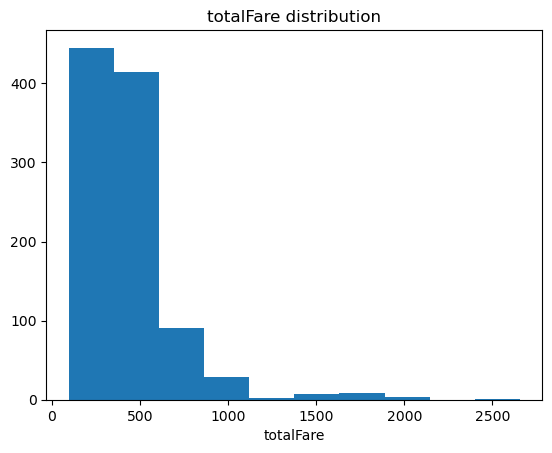

In [15]:
sdf2 = sdf.limit(1000) 
pdf = sdf2.toPandas()  

plt.hist(pdf['totalFare'])
plt.xlabel('totalFare')  
plt.title('totalFare distribution')  
plt.show()  
#distribution of total fare

In [22]:
pdf.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach
3,969a269d38eae583f455486fa90877b4,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H32M,0,False,False,...,1650227460,2022-04-17T16:31:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9120,947,coach
4,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach


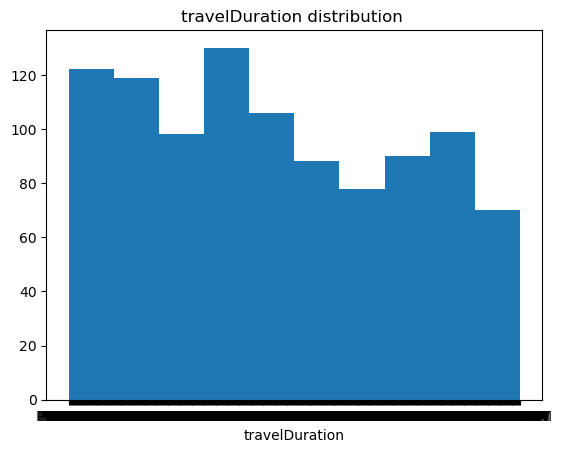

In [16]:
plt.hist(pdf['travelDuration'])
plt.xlabel('travelDuration')  
plt.title('travelDuration distribution ')  
plt.show()  
#travel ditribution

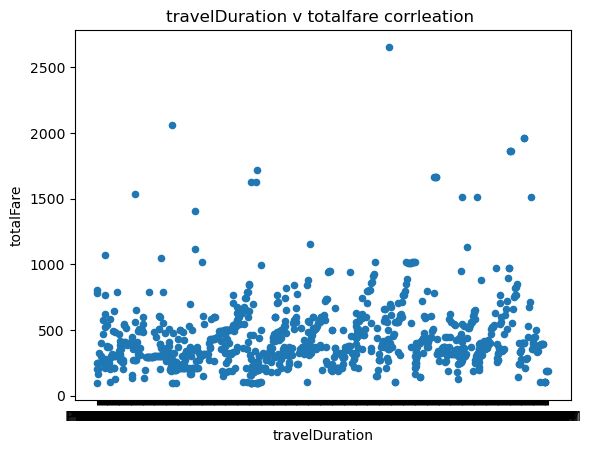

In [17]:
pdf.plot(kind='scatter', x= 'travelDuration', y = 'totalFare')
plt.title('travelDuration v totalfare corrleation ')  

plt.show()
#correlation between travel duration and total fare

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

sdf2 = sdf.limit(1000) 
vector_col="corr_features"
col = ['elapsedDays','isBasicEconomy', 'isNonStop', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
assembler = VectorAssembler(inputCols=col, outputCol=vector_col, handleInvalid="skip")

sdf2_vector= assembler.transform(sdf2).select(vector_col)
sdf2_vector
#creating correlation matrix to check for correlation between features + label 
#with help from https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame
# and https://www.statology.org/pyspark-correlation-matrix/

matrix= Correlation.corr(sdf2_vector, vector_col).collect()[0][0]
matrix

corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = col, index=col) 
corr_matrix_df

,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance
elapsedDays,1.000000,0.270959,-0.309377,-0.024178,-0.013642,0.257990,0.287059
isBasicEconomy,0.270959,1.000000,-0.244747,-0.230712,-0.224650,0.501427,0.352479
isNonStop,-0.309377,-0.244747,1.000000,0.092389,0.072377,-0.102873,-0.535932
baseFare,-0.024178,-0.230712,0.092389,1.000000,0.999764,-0.197157,0.009262
totalFare,-0.013642,-0.224650,0.072377,0.999764,1.000000,-0.193569,0.021199
seatsRemaining,0.257990,0.501427,-0.102873,-0.197157,-0.193569,1.000000,0.361027
totalTravelDistance,0.287059,0.352479,-0.535932,0.009262,0.021199,0.361027,1.000000


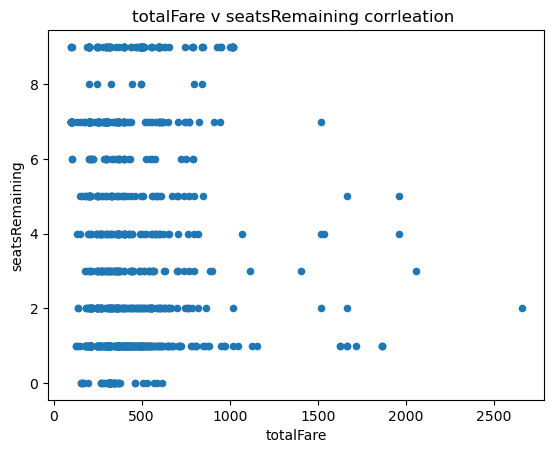

In [19]:
pdf.plot(kind='scatter', x= 'totalFare', y = 'seatsRemaining')
plt.title('totalFare v seatsRemaining corrleation ')  

plt.show()

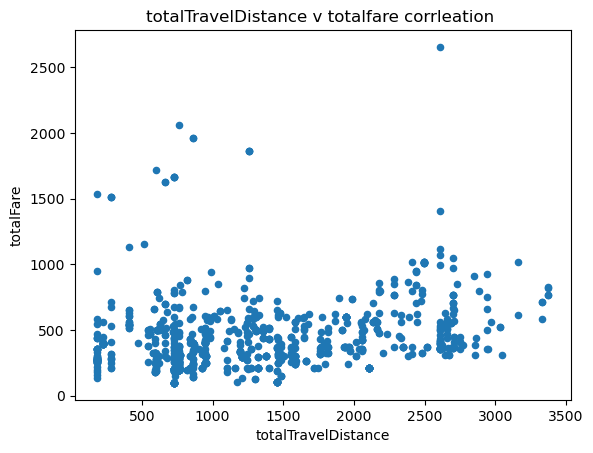

In [20]:
pdf.plot(kind='scatter', x= 'totalTravelDistance', y = 'totalFare')
plt.title('totalTravelDistance v totalfare corrleation ')  

plt.show()